In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ------------------ #
import datetime as dt
import pandas as pd
import numpy as np
import sys

# sys.path.insert(0, '../project/qdb/')
from qdb import QdbApi
q = QdbApi(user="read_only", password="read_only20716")

成功链接数据库：url=fundinfo.cq1tbd5lkqzo.rds.cn-northwest-1.amazonaws.com.cn:3306，user=read_only)
连接Arctic失败：mongo_uri=None)


In [2]:
# from qdb import QdbUpdater
# self = QdbUpdater()
# self.init(user="read_only", password="read_only20716")

In [3]:
# self.em.csd(
#     "000300.SH",
#     # 市盈率PE(TTM) 市盈率PE（最新年报） 市盈率PE中位值（TTM） 市盈率PE中位值（最新年报） 市净率PB中位值（MRQ） 市净率PB中位值（最新年报） 市净率PB中位值（最新公告）
#     "PETTM,PELYR,PEMIDTTM,PEMIDLYR,PBMIDMRQ,PBMIDLYR,PBMIDLF",
#     "2022-04-08","2022-04-29",
#     "DelType=1,period=1,adjustflag=1,curtype=1,order=1,market=CNSESH,ispandas=1"
# )

In [4]:
def cal_period_perf_indicator(df):
    """
    计算区间业绩指标(高级版)
    Input
        df: 价格或净值序列，DataFrame, index是datetime.date，每列是一只基金
    Output
        ['AnnRet1', 'AnnRet2', 'AnnVol', 'SR', 'MaxDD', 'Calmar'] 
    """

    assert type(df)==pd.DataFrame
    assert type(df.index[0])==dt.date
    
    indicators = ['AnnRet', 'AnnRet_Simple', 'AnnVol', 'SR', 'MaxDD', 'Calmar']
    res = pd.DataFrame(index=df.columns, columns=indicators)
    date_ordinal = pd.Series([dt.date.toordinal(e) for e in df.index])
    time_diff = date_ordinal - date_ordinal.shift(1) # 相对上一次净值的日期间隔
    for col in df:    
        p = df[col] # 单个资产价格或净值序列, pd.Series
        r = p.pct_change() # 涨幅
        annret = (p[-1] / p[0]) ** (365/(p.index[-1]-p.index[0]).days) - 1 # 复利年化收益
        r1 = r.values / time_diff # 日均收益
        annret1 = np.nanmean(r1) * 365 # 单利年化收益
        r2 = r.values / np.sqrt(time_diff) # 波动率调整后涨幅   
        annvol = np.nanstd(r2) * np.sqrt(365) # 年化波动率
        sr = (annret - 0.025) / annvol # 夏普比率
        mdd = np.min(p/p.cummax() - 1) # 最大回撤
        calmar = annret / -mdd
        res.loc[col] = [annret, annret1, annvol, sr, mdd, calmar]

    return res

In [5]:
start_date = q.get_index_list("000300.CSI")["start_date"].squeeze()
end_date = dt.date(2022, 4, 28)

更新了缓存数据：index_list


In [6]:
# 获取沪深300指数历史日行情数据
hs300_daily = q.get_index_daily("000300.CSI", start_date=start_date, end_date=end_date)
hs300_daily.set_index("date", inplace=True)
del hs300_daily["index_id"]

In [7]:
hs300_daily

,open,high,low,close
date,,,,
2004-12-31,1000.00,1000.00,1000.00,1000.000
2005-01-04,994.77,994.77,980.66,982.794
2005-01-05,981.58,997.32,979.88,992.564
2005-01-06,993.33,993.79,980.33,983.174
2005-01-07,983.05,995.71,979.81,983.958
...,...,...,...,...
2022-04-22,3967.20,4037.08,3953.72,4013.250
2022-04-25,3933.45,3958.21,3814.91,3814.910
2022-04-26,3822.49,3871.85,3773.90,3784.120


In [9]:
# 计算沪深300净值
ret_daily = hs300_daily["close"].pct_change()
net_daily = (ret_daily + 1).cumprod()
net_daily.iloc[0] = 1
net_daily.name = "CSI 300 Index"

# 计算动量
mtm_sgn = hs300_daily["close"].pct_change(periods=20)
mtm_sgn = mtm_sgn[20:]
mtm_sgn.name = "Momentum"

# 检查缺失值
assert not (mtm_sgn.isnull().any())

df = pd.DataFrame(mtm_sgn)

In [10]:
# 100个工作日滚动分位数
df["fcst"] = mtm_sgn.index.map(lambda _date: mtm_sgn.loc[q.tdate_shift(_date, -100): _date].rank(pct=True)[-1])

In [11]:
df

,Momentum,fcst
date,,
2005-01-31,-0.045121,1.000000
2005-02-01,-0.027313,1.000000
2005-02-02,0.014453,1.000000
2005-02-03,0.010213,0.750000
2005-02-04,0.033438,1.000000
...,...,...
2022-04-22,-0.061562,0.207921
2022-04-25,-0.102651,0.029703
2022-04-26,-0.093531,0.059406


In [12]:
# ADF检验
print(f"Momentum's p-value = {sm.tsa.stattools.adfuller(df['Momentum'].dropna())[1]}")
print(f"fcst's p-value = {sm.tsa.stattools.adfuller(df['fcst'].dropna())[1]}")

Momentum's p-value = 3.979640647654645e-11
fcst's p-value = 3.8663573077325147e-19


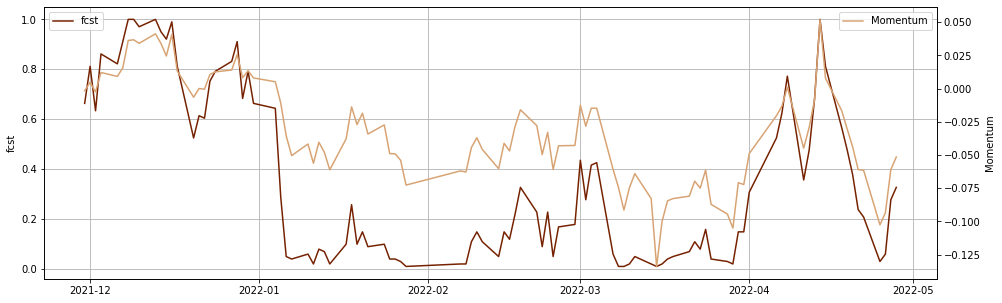

In [13]:
# fig, (ax, ax_kde) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True, dpi=1000)
fig, ax = plt.subplots(figsize=(16, 5))
ax.grid()
ax.plot(df['fcst'][-100:], color="#752100", label="fcst")
ax.set_ylabel('fcst')
ax.legend(loc="upper left")

ax_twinx = ax.twinx()
ax_twinx.plot(df['Momentum'][-100:], color="#d8a373", label="Momentum")
ax_twinx.set_ylabel('Momentum')
ax_twinx.legend(loc="upper right")

# sns.kdeplot(mtm_sgn, shade=True,xw color="#752100", ax=ax_kde, label=mtm_sgn.name)
# ax_kde.hist(mtm_sgn, bins=1000, orientation="horizontal", color="#752100", label=mtm_sgn.name)
# ax_kde.set_title("Kernel Density Estimation")
# ax_kde.legend()

fig.show()

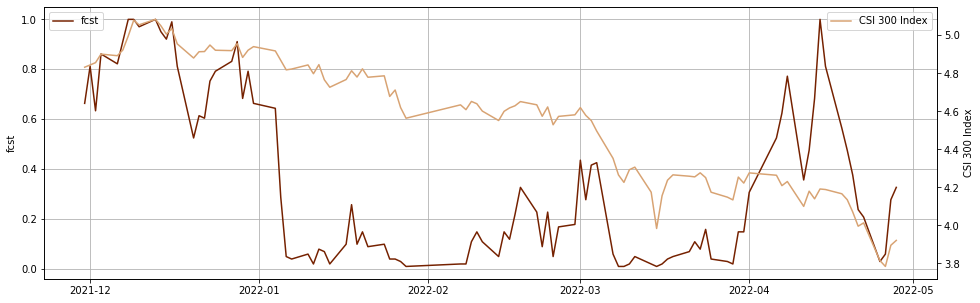

In [14]:
# fig, (ax, ax_kde) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True, dpi=1000)
fig, ax = plt.subplots(figsize=(16, 5))
ax.grid()
ax.plot(df['fcst'][-100:], color="#752100", label="fcst")
ax.set_ylabel('fcst')
ax.legend(loc="upper left")

ax_twinx = ax.twinx()
ax_twinx.plot(net_daily[-100:], color="#d8a373", label=net_daily.name)
ax_twinx.set_ylabel(net_daily.name)
ax_twinx.legend(loc="upper right")

fig.show()

## 指标按取值分组

In [15]:
def value_to_group(value, bins):
    group = sum(value >= bins)
    if group == len(bins):
        return group - 1
    return group

def group_to_interval(group, bins):
    left = bins[group - 1]
    right = bins[group]
    if group == 1:
        return pd.Interval(-np.inf, right)
    elif group == 20:
        return pd.Interval(left, np.inf)
    else:
        return pd.Interval(left, right)

### 指标分组展示

In [16]:
# 数据分箱，等分为20组
# TODO: 使用滚动五年分位数
fcst_bins = np.linspace(0, 1, num=21)
fcst_groups = df["fcst"].apply(value_to_group, bins=fcst_bins)
fcst_groups.name = fcst_groups.name + " Group"
fcst_groups.value_counts().sort_index()

1     318
2     193
3     178
4     148
5     220
6     179
7     216
8     181
9     195
10    204
11    221
12    214
13    199
14    227
15    223
16    207
17    196
18    153
19    186
20    331
Name: fcst Group, dtype: int64

## 沪深300未来一段时间平均涨跌幅

分别选择5、21、63个交易日，对应沪深300未来一周、一月、一季度走势
$$
ret^*_{5}(t) := Ret(t^*+1, t+5) = \frac{Close(t+5)}{Open(t+1)} - 1
$$
$$
ret^*_{21}(t) := Ret(t^*+1, t+21) = \frac{Close(t+21)}{Open(t+1)} - 1
$$
$$
ret^*_{63}(t) := Ret(t^*+1, t+63) = \frac{Close(t+63)}{Open(t+1)} - 1
$$

In [17]:
ret_5 = hs300_daily["close"].shift(-5) / hs300_daily["open"].shift(-1) - 1
ret_21 = hs300_daily["close"].shift(-21) / hs300_daily["open"].shift(-1) - 1
ret_63 = hs300_daily["close"].shift(-63) / hs300_daily["open"].shift(-1) - 1

assert (ret_5.isna().sum() == 5) # 核对是否只缺少5个日期
assert (ret_21.isna().sum() == 21) # 核对是否只缺少21个日期
assert (ret_63.isna().sum() == 63) # 核对是否只缺少63个日期

ret_5.dropna(inplace=True)
ret_21.dropna(inplace=True)
ret_63.dropna(inplace=True)

ret_5.name, ret_21.name, ret_63.name = "ret_5", "ret_21", "ret_63"

df = pd.concat([df, fcst_groups, ret_5, ret_21, ret_63], join="inner", axis=1)
df

,Momentum,fcst,fcst Group,ret_5,ret_21,ret_63
date,,,,,,
2005-01-31,-0.045121,1.000000,20,0.073689,0.072462,-0.081880
2005-02-01,-0.027313,1.000000,20,0.066803,0.073931,-0.078643
2005-02-02,0.014453,1.000000,20,0.000487,0.025329,-0.121687
2005-02-03,0.010213,0.750000,16,0.033641,0.021436,-0.108923
2005-02-04,0.033438,1.000000,20,0.022886,-0.019789,-0.137354
...,...,...,...,...,...,...
2022-01-14,-0.061175,0.019802,1,0.010690,-0.019974,-0.151310
2022-01-17,-0.037838,0.099010,2,0.004187,-0.040411,-0.199688
2022-01-18,-0.013743,0.257426,6,-0.028523,-0.040026,-0.214230


## 计算“上涨机会得分”和“下跌风险得分”

排在前1/4的累积频率

In [18]:
fcst_group_mean_ret = df.groupby(by="fcst Group").mean()
fcst_group_mean_ret

,Momentum,fcst,ret_5,ret_21,ret_63
fcst Group,,,,,
1,-0.102364,0.025018,0.009596,0.025003,0.046281
2,-0.082323,0.076403,0.003955,0.019887,0.023109
3,-0.072039,0.127143,-0.000274,0.002254,0.013751
4,-0.062233,0.175968,-0.001013,0.010299,0.038960
5,-0.033419,0.227397,-0.000081,-0.001325,0.014333
6,-0.029950,0.277629,0.001004,0.006477,0.022774
7,-0.016316,0.325693,-0.001780,0.005395,0.024932
8,-0.011724,0.376831,0.005318,0.002834,0.025868
9,-0.003038,0.426896,-0.000085,0.010078,0.040248


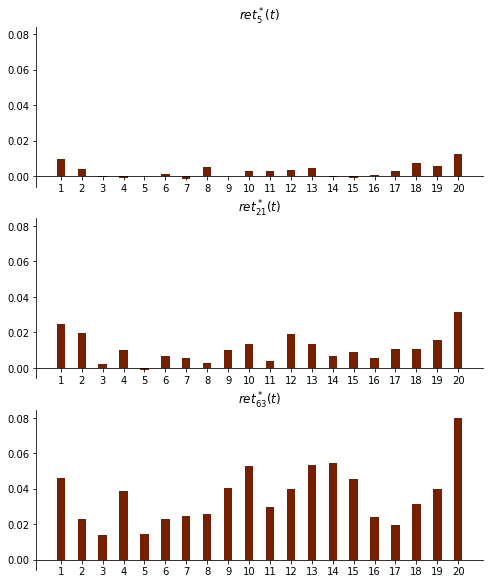

In [19]:
fig, (ax_0, ax_1, ax_2) = plt.subplots(3, 1, sharey=True, figsize=(8, 10))

ax_0.bar(fcst_group_mean_ret.index, fcst_group_mean_ret["ret_5"], width=.4, color="#752100")
ax_0.set_xticks(fcst_group_mean_ret.index)
ax_0.set_title("$ret^*_{5}(t)$")
ax_0.spines["top"].set_color("none")
ax_0.spines["right"].set_color("none")
ax_0.spines["bottom"].set_position(("data", 0))

ax_1.bar(fcst_group_mean_ret.index, fcst_group_mean_ret["ret_21"], width=.4, color="#752100")
ax_1.set_xticks(fcst_group_mean_ret.index)
ax_1.set_title("$ret^*_{21}(t)$")
ax_1.spines["top"].set_color("none")
ax_1.spines["right"].set_color("none")
ax_1.spines["bottom"].set_position(("data", 0))

ax_2.bar(fcst_group_mean_ret.index, fcst_group_mean_ret["ret_63"], width=.4, color="#752100")
ax_2.set_xticks(fcst_group_mean_ret.index)
ax_2.set_title("$ret^*_{63}(t)$")
ax_2.spines["top"].set_color("none")
ax_2.spines["right"].set_color("none")
ax_2.spines["bottom"].set_position(("data", 0))

fig.show()

## 指标择时效果

In [20]:
short_trigger_point = group_to_interval(group=2, bins=fcst_bins).right
short_close_point = group_to_interval(group=5, bins=fcst_bins).right
long_trigger_point = group_to_interval(group=19, bins=fcst_bins).left
long_close_point = group_to_interval(group=16, bins=fcst_bins).left

print(short_trigger_point, short_close_point)
print(long_trigger_point, long_close_point)

0.1 0.25
0.9 0.75


- 当指标在0.1以下时，做空沪深300，直到指标恢复到0.25以上，恢复平仓。
- 当指标在0.9以上时，做多沪深300，直到指标恢复到0.75以下，恢复平仓。
- 其余时间，维持平仓状态。
- 调仓均以出现信号第二天的开盘价买入/卖出。

In [21]:
# TODO: 仓位不变有问题


df["pos"] = np.nan
df["stgy_ret"] = np.nan

for _date in df.index:
    if _date == df.index[0]:
        df.loc[_date, "pos"] = 0
        df.loc[_date, "stgy_ret"] = 0
        continue
    _fcst = df.shift(1).loc[_date, "fcst"]

    if (_fcst > short_close_point) and (_fcst < long_close_point):
        _pos = 0 # 平仓
        _ret = 0
    elif (_fcst < short_trigger_point):
        _pos = -1 # 做空
        _ret = 1 - hs300_daily.loc[_date, "close"] / hs300_daily.loc[_date, "open"]
    elif (_fcst > long_trigger_point):
        _pos = 1 # 做多
        _ret = hs300_daily.loc[_date, "close"] / hs300_daily.loc[_date, "open"] - 1
    else:
        _pos = df.shift(1).loc[_date, "pos"] # 仓位不变
        _ret = hs300_daily.loc[_date, "close"] / hs300_daily.shift(1).loc[_date, "close"] - 1
        _ret = _ret if _pos == 1 else (-_ret) if _pos == -1 else 0 # 调整符号

    df.loc[_date, "pos"] = _pos
    df.loc[_date, "stgy_ret"] = _ret

assert (not df.isna().any().any()) # 检查

In [22]:
# TODO: 指标历次看多与看空区间收益统计

In [23]:
backtest_start_date = q.prev_tdate(df.index[0], exch='sse')
df["stgy"] = (1 + df["stgy_ret"]).cumprod() * hs300_daily.loc[backtest_start_date, "close"]
try:
    df = df.join(hs300_daily["close"])
except:
    pass

In [24]:
df

,Momentum,fcst,fcst Group,ret_5,ret_21,ret_63,pos,stgy_ret,stgy,close
date,,,,,,,,,,
2005-01-31,-0.045121,1.000000,20,0.073689,0.072462,-0.081880,0.0,0.000000,969.209000,954.879
2005-02-01,-0.027313,1.000000,20,0.066803,0.073931,-0.078643,1.0,0.002749,971.873656,955.951
2005-02-02,0.014453,1.000000,20,0.000487,0.025329,-0.121687,1.0,0.052482,1022.880008,1006.910
2005-02-03,0.010213,0.750000,16,0.033641,0.021436,-0.108923,1.0,-0.012277,1010.322374,993.215
2005-02-04,0.033438,1.000000,20,0.022886,-0.019789,-0.137354,1.0,0.023807,1034.374642,1016.860
...,...,...,...,...,...,...,...,...,...,...
2022-01-14,-0.061175,0.019802,1,0.010690,-0.019974,-0.151310,-1.0,0.003621,1237.393485,4726.730
2022-01-17,-0.037838,0.099010,2,0.004187,-0.040411,-0.199688,-1.0,-0.008146,1227.313803,4767.280
2022-01-18,-0.013743,0.257426,6,-0.028523,-0.040026,-0.214230,-1.0,-0.009770,1215.323318,4813.350


,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,0.10008,0.09525,0.283759,0.264589,-0.723038,0.138415
stgy,0.012847,-0.041943,0.18214,-0.066721,-0.571597,0.022476


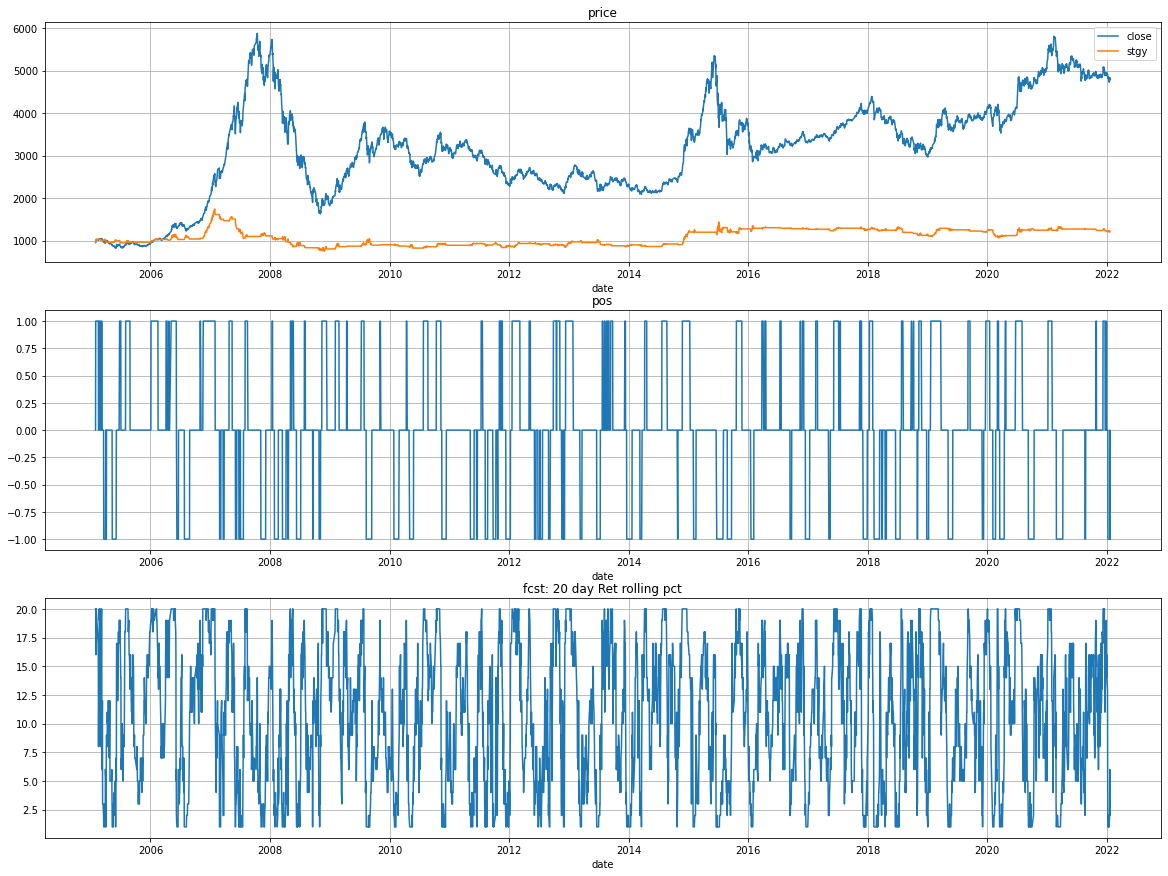

In [25]:
# 展示回测结果
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(3,1,1)
df.loc[backtest_start_date:, ['close', 'stgy']].plot(ax=ax1, grid=True, title='price')
ax2 = fig.add_subplot(3,1,2)
df.loc[backtest_start_date:, 'pos'].plot(ax=ax2, grid=True, title='pos')
ax3 = fig.add_subplot(3,1,3)
df.loc[backtest_start_date:, 'fcst Group'].plot(ax=ax3, grid=True, title='fcst: 20 day Ret rolling pct')

cal_period_perf_indicator(df.loc[backtest_start_date:,['close','stgy']])